In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv


In [2]:
!pip install stargazer -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import statsmodels.api as sm
from stargazer.stargazer import Stargazer

/opt/conda/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [4]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv") 
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

In [5]:
df_origi = pd.read_csv('/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv')

In [6]:
df_origi.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [7]:
from sklearn import datasets

diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data)
df.columns = ['Age', "Sex", 'BMI','ABP', 'S1', 'S2', "S3", 'S4', 'S5', 'S6']
df['target'] = diabetes.target

est = sm.OLS(endog = df['target'], exog = sm.add_constant(df[df.columns[0:4]])).fit()
est2 = sm.OLS(endog = df['target'], exog = sm.add_constant(df[df.columns[0:6]])).fit()    

stargazer = Stargazer([est, est2])

In [8]:
stargazer

In [9]:
df_origi.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [10]:
df_origi.shape

(32581, 12)

In [11]:
df_train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [12]:
df_train.shape

(58645, 13)

In [13]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [14]:
df_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [15]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [16]:
df_sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [17]:
df_train = df_train.drop(columns = ['id'])
df_test = df_test.drop(columns = ['id'])

In [18]:
df_train.shape , df_test.shape

((58645, 12), (39098, 11))

In [19]:
df_train = pd.concat([df_train, df_origi], axis = 0)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [21]:
df_train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [22]:
df_test.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [23]:
def Na_mean_change(df, features):
    
    for col in features:
        df[col].fillna(df[col].mean(), inplace = True)
    
    pd.DataFrame(df)
    return df

'''
df_train['person_emp_length'].fillna(df_train['person_emp_length'].mean(), inplace = True)
df_train['loan_int_rate'].fillna(df_train['loan_int_rate'].mean(), inplace = True)
'''

"\ndf_train['person_emp_length'].fillna(df_train['person_emp_length'].mean(), inplace = True)\ndf_train['loan_int_rate'].fillna(df_train['loan_int_rate'].mean(), inplace = True)\n"

In [24]:
df_train = Na_mean_change(df_train, ['person_emp_length', 'loan_int_rate'])

/tmp/ipykernel_18/918174096.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace = True)


In [25]:
df_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


In [26]:
df_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

# EDA!!

In [27]:
def stacked_bar_cmap(df, feature, color = 'coolwarm', target = 'loan_status'):
    
    crosstab = pd.crosstab(df[feature], df[target], normalize = 'index')
    
    crosstab.plot(kind = 'bar', stacked = 'True', figsize = (12,6),
                 cmap = color)
    
    plt.title(f"Stacked Bar Plot of {feature} against {target}")
    plt.ylabel('Proportion')
    plt.xticks(rotation = 45)
    plt.show()

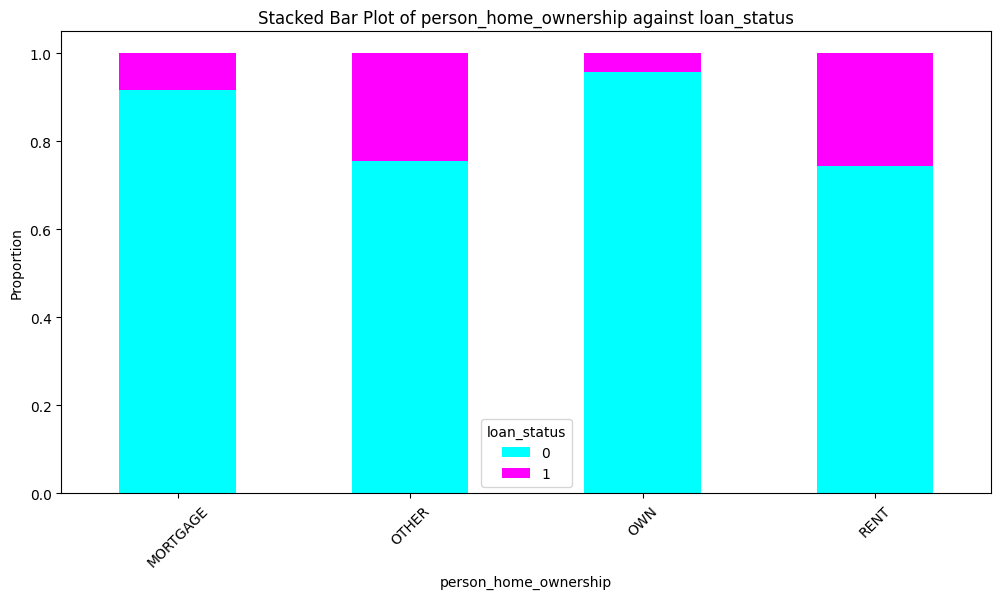

In [28]:
stacked_bar_cmap(df_train, 'person_home_ownership', color = 'cool')

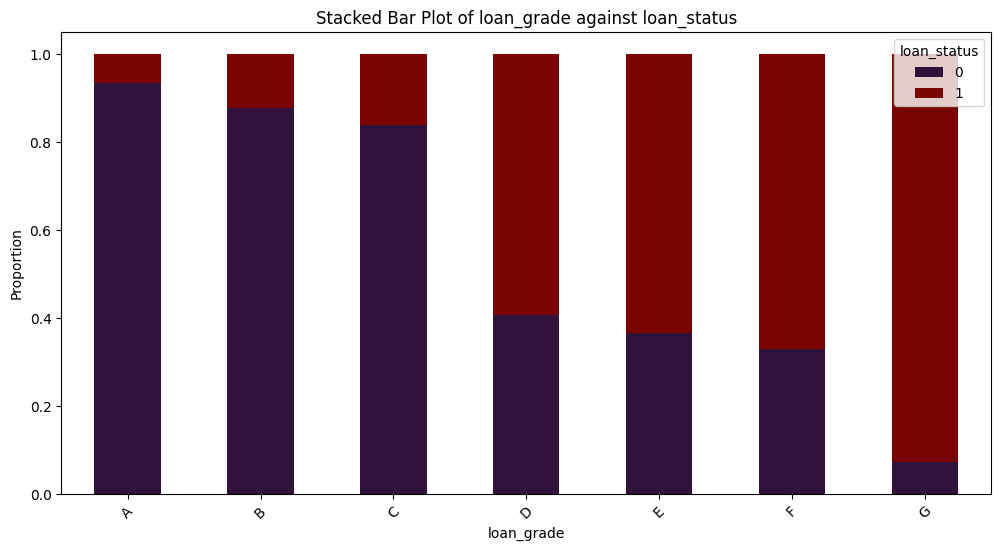

In [29]:
stacked_bar_cmap(df_train, 'loan_grade', color = 'turbo')

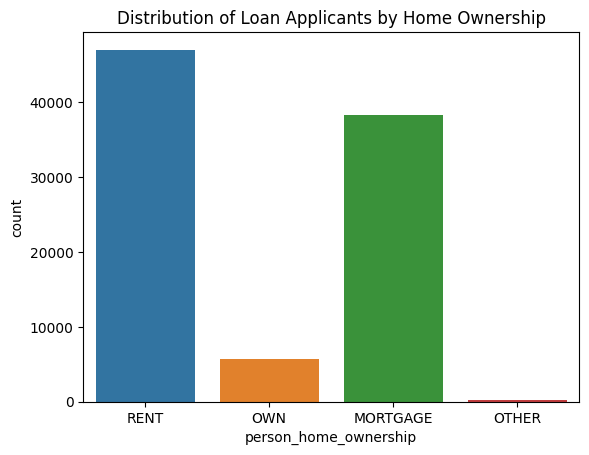

In [30]:
sns.countplot(data=df_train, x='person_home_ownership')
plt.title('Distribution of Loan Applicants by Home Ownership')
plt.show()

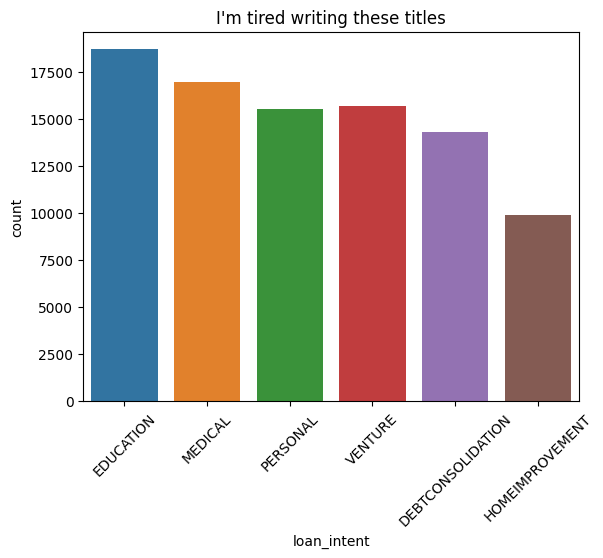

In [31]:
sns.countplot(data = df_train, x = 'loan_intent')
plt.title('I\'m tired writing these titles')
plt.xticks(rotation = 45)
plt.show()          

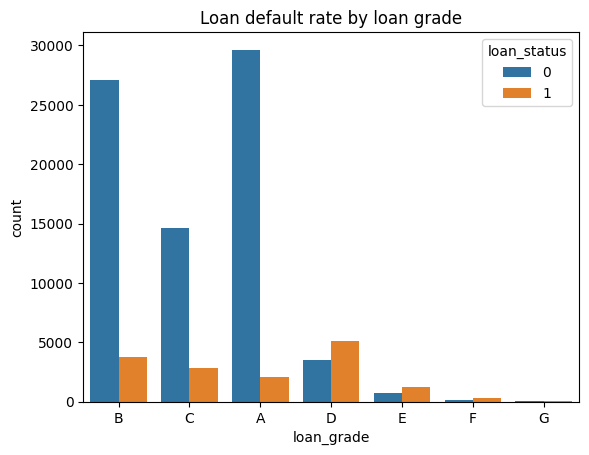

In [32]:
sns.countplot(data = df_train, x = 'loan_grade', hue = 'loan_status')
plt.title('Loan default rate by loan grade')
plt.show()

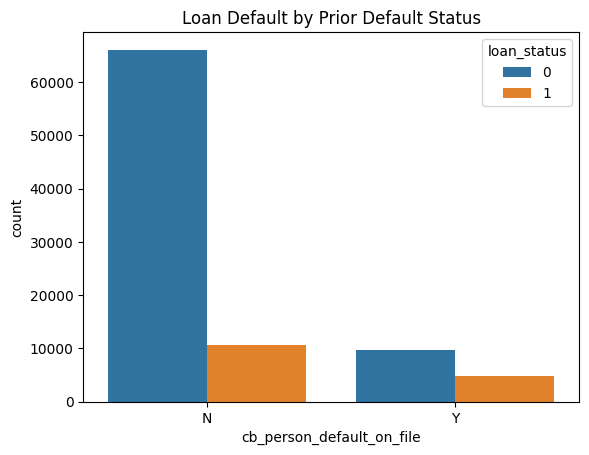

In [33]:
sns.countplot(data=df_train, x='cb_person_default_on_file', hue='loan_status')
plt.title('Loan Default by Prior Default Status')
plt.show()

In [34]:
def boxplots(df, columns):
    plt.Figure(figsize = (12,6))
    
    for i, col in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.boxplot(y = df[col], color = 'blue')
        plt.title(f'Boxplot of {col}')
        
    plt.tight_layout()
    plt.show()

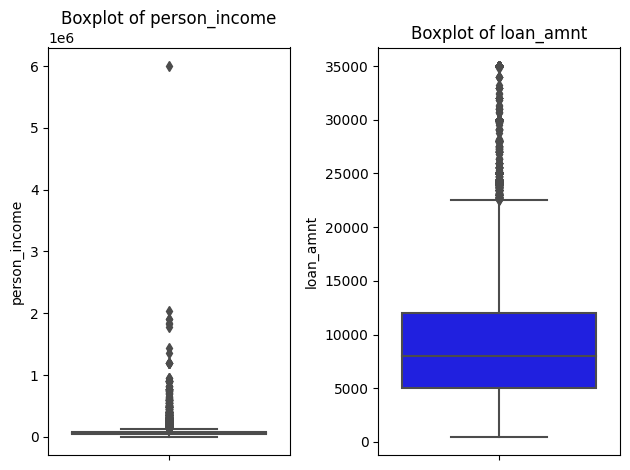

In [35]:
boxplots(df_train, ['person_income', 'loan_amnt'])

In [36]:
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df_train, df_test):
    label_enc = LabelEncoder()
    
    label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']
    
    for col in label_cols:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_test[col] = label_enc.transform(df_test[col])
        
    df_train = pd.get_dummies(df_train, columns = ['loan_intent'], drop_first = True)
    df_test = pd.get_dummies(df_test, columns = ['loan_intent'], drop_first = True)
    
    target_col = 'loan_status'
    train_columns = df_train.drop(columns =[target_col]).columns
    
    df_test = df_test.reindex(columns = train_columns, fill_value = 0)
    
    return df_train, df_test

In [37]:
df_train2, df_test2 = preprocess_data(df_train, df_test)

In [38]:
# lat're...

# Analysis Using Regression

In [39]:
df_train = df_train2
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   91226 non-null  int64  
 1   person_income                91226 non-null  int64  
 2   person_home_ownership        91226 non-null  int64  
 3   person_emp_length            91226 non-null  float64
 4   loan_grade                   91226 non-null  int64  
 5   loan_amnt                    91226 non-null  int64  
 6   loan_int_rate                91226 non-null  float64
 7   loan_percent_income          91226 non-null  float64
 8   cb_person_default_on_file    91226 non-null  int64  
 9   cb_person_cred_hist_length   91226 non-null  int64  
 10  loan_status                  91226 non-null  int64  
 11  loan_intent_EDUCATION        91226 non-null  bool   
 12  loan_intent_HOMEIMPROVEMENT  91226 non-null  bool   
 13  loan_intent_MEDICAL  

In [40]:
df_train.describe()

,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,91226.000000,91226.000000,91226.000000,91226.000000,91226.000000,91226.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,1.674523,4.732119,1.120766,9350.348607,10.789508,0.163154,0.158365,5.810219,0.169447
std,6.148115,4.793696e+04,1.445621,4.005274,1.093023,5848.605423,3.055439,0.097491,0.365085,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,0.000000,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,0.000000,2.000000,0.000000,5000.000000,7.880000,0.090000,0.000000,3.000000,0.000000
50%,26.000000,5.700000e+04,3.000000,4.000000,1.000000,8000.000000,10.789508,0.140000,0.000000,4.000000,0.000000
75%,30.000000,7.800000e+04,3.000000,7.000000,2.000000,12000.000000,12.990000,0.220000,0.000000,8.000000,0.000000
max,144.000000,6.000000e+06,3.000000,123.000000,6.000000,35000.000000,23.220000,0.830000,1.000000,30.000000,1.000000


In [41]:
# using linear regression
import statsmodels.api as sm
from statsmodels.formula.api import ols

from stargazer.stargazer import Stargazer

col_names = 'person_age+person_income+person_home_ownership+person_emp_length+loan_grade+loan_amnt+loan_int_rate+loan_percent_income+cb_person_default_on_file+cb_person_cred_hist_length + loan_status'

model1 = ols('loan_amnt ~ person_income + person_age + person_emp_length + person_home_ownership', data = df_train).fit()
model2 = ols('loan_amnt ~ person_income + person_age + person_emp_length', data = df_train).fit()
model3 = ols('loan_amnt ~ person_age+person_income+person_home_ownership+person_emp_length+loan_grade+loan_int_rate+loan_percent_income+cb_person_default_on_file+cb_person_cred_hist_length + loan_status', data = df_train).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loan_amnt   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        06:15:16   Log-Likelihood:            -8.7635e+05
No. Observations:               91226   AIC:                         1.753e+06
Df Residuals:                   91215   BIC:                         1.753e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1868.2845    116.428    -16.047      0.000   -2096.483   -1640.086
person_age                   -12.4759      3.932     -3.173      0.002     -20.183      -4.769
person_income                  0.0537      0.000    201.459      0.000       0.053       0.054
person_home_ownership       -462.0328      8.950    -51.622      0.000    -479.575    -444.490
person_emp_length             71.0763      3.124     22.753      0.000      64.954      77.199
loan_grade                   397.9233     29.098     13.675      0.000     340.891     454.955
loan_int_rate                 56.6852      9.851      5.755      0.000      37.378      75.992
loan_percent_income         4.666e+04    135.784    343.667      0.000    4.64e+04    4.69e+04
cb_person_default_on_file   -306.2696     38.983     -7.857      0.000    -382.676    -229.863
cb_person_cred_hist_length    31.0637      5.949      5.221      0.000      19.403      42.724
loan_status                -1644.5962     37.265    -44.133      0.000   -1717.634   -1571.558
==============================================================================
Omnibus:                   142638.652   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1872493542.890
Skew:                          -8.824   Prob(JB):                         0.00
Kurtosis:                     704.648   Cond. No.                     9.54e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
stargazer = Stargazer([model1, model2, model3])
stargazer

In [43]:
# test VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_train.iloc[:, :-5]

def VFI_calc(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    df = vif_data.sort_values("VIF").reset_index(drop=True)
    return df

In [44]:
VFI_calc(X)
# loan_grade, loan_percent_income seems sus, 
# and loan_int_rate, person_age are defenitly SUS

,feature,VIF
0,loan_status,1.695093
1,cb_person_default_on_file,1.699070
2,person_emp_length,2.629123
3,person_home_ownership,2.826132
4,person_income,4.625955
5,cb_person_cred_hist_length,9.282739
6,loan_amnt,9.382602
7,loan_grade,10.259760
8,loan_percent_income,10.517703
9,loan_int_rate,48.372716


In [45]:
list(df_train.columns)

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length',
 'loan_status',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE']

In [46]:
# basic logit.reg
from statsmodels.formula.api import logit

model_all = logit('loan_status ~ person_age+person_income+person_home_ownership+person_emp_length+loan_grade+loan_int_rate+loan_percent_income+cb_person_default_on_file+cb_person_cred_hist_length + loan_amnt + loan_intent_EDUCATION + loan_intent_HOMEIMPROVEMENT +loan_intent_MEDICAL +loan_intent_PERSONAL +loan_intent_VENTURE', data = df_train).fit()
model_all.summary()

Optimization terminated successfully.
         Current function value: 0.300508
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                91226
Model:                          Logit   Df Residuals:                    91210
Method:                           MLE   Df Model:                           15
Date:                Tue, 15 Oct 2024   Pseudo R-squ.:                  0.3396
Time:                        06:15:19   Log-Likelihood:                -27414.
converged:                       True   LL-Null:                       -41509.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.5912      0.120    -38.192      0.000      -4.827      -4.356
loan_intent_EDUCATION[T.True]          -0.9404      0.036    -25.767      0.000      -1.012      -0.869
loan_intent_HOMEIMPROVEMENT[T.True]    -0.0531      0.040     -1.312      0.189      -0.132       0.026
loan_intent_MEDICAL[T.True]            -0.2864      0.034     -8.346      0.000      -0.354      -0.219
loan_intent_PERSONAL[T.True]           -0.6415      0.037    -17.274      0.000      -0.714      -0.569
loan_intent_VENTURE[T.True]            -1.1964      0.040    -29.916      0.000      -1.275      -1.118
person_age                              0.0050      0.004      1.386      0.166      -0.002       0.012
person_income                       -1.252e-07    5.7e-07     -0.220      0.826   -1.24e-06    9.92e-07
person_home_ownership                   0.3050      0.009     33.346      0.000       0.287       0.323
person_emp_length                      -0.0140      0.003     -4.546      0.000      -0.020      -0.008
loan_grade                              1.0897      0.024     44.814      0.000       1.042       1.137
loan_int_rate                          -0.0319      0.009     -3.491      0.000      -0.050      -0.014
loan_percent_income                    13.1187      0.202     64.988      0.000      12.723      13.514
cb_person_default_on_file              -0.1405      0.028     -4.942      0.000      -0.196      -0.085
cb_person_cred_hist_length             -0.0078      0.006     -1.407      0.160      -0.019       0.003
loan_amnt                           -8.262e-05   3.59e-06    -23.002      0.000   -8.97e-05   -7.56e-05
=======================================================================================================
"""

In [47]:
# Use PCA to handle Dimentions, and fit data

from sklearn.decomposition import PCA

pca = PCA(n_components = 12)
df_train_pca = pca.fit(df_train)